In [1]:
import pandas as pd

Image name, along with the text extracted from each image is stored as text columns. Sentiments corresponding to each image is recorded in the overall_sentiment column. We will create a classification model around this dataset.

In [2]:
df = pd.read_csv('labels.csv')
df.shape

(6992, 5)

In [3]:
df.head()

,Unnamed: 0,image_name,text_ocr,text_corrected,overall_sentiment
0,0,image_1.jpg,LOOK THERE MY FRIEND LIGHTYEAR NOW ALL SOHALIK...,LOOK THERE MY FRIEND LIGHTYEAR NOW ALL SOHALIK...,very_positive
1,1,image_2.jpeg,The best of #10 YearChallenge! Completed in le...,The best of #10 YearChallenge! Completed in le...,very_positive
2,2,image_3.JPG,Sam Thorne @Strippin ( Follow Follow Saw every...,Sam Thorne @Strippin ( Follow Follow Saw every...,positive
3,3,image_4.png,10 Year Challenge - Sweet Dee Edition,10 Year Challenge - Sweet Dee Edition,positive
4,4,image_5.png,10 YEAR CHALLENGE WITH NO FILTER 47 Hilarious ...,10 YEAR CHALLENGE WITH NO FILTER 47 Hilarious ...,neutral


In [4]:
# First column is Unnamed, we can drop it

df = df.drop(df.columns[0], axis = 1)
df.head(3)

,image_name,text_ocr,text_corrected,overall_sentiment
0,image_1.jpg,LOOK THERE MY FRIEND LIGHTYEAR NOW ALL SOHALIK...,LOOK THERE MY FRIEND LIGHTYEAR NOW ALL SOHALIK...,very_positive
1,image_2.jpeg,The best of #10 YearChallenge! Completed in le...,The best of #10 YearChallenge! Completed in le...,very_positive
2,image_3.JPG,Sam Thorne @Strippin ( Follow Follow Saw every...,Sam Thorne @Strippin ( Follow Follow Saw every...,positive


In [5]:
# Checking for null

df.isna().sum()

image_name             0
text_ocr             161
text_corrected         5
overall_sentiment      0
dtype: int64

There are some Null in text_ocr and text_corrected. Text corrected and text ocr are almost same. We can keep the text corrected only.

In [6]:
df = df.drop(df.columns[1], axis = 1)
df.head(3)

,image_name,text_corrected,overall_sentiment
0,image_1.jpg,LOOK THERE MY FRIEND LIGHTYEAR NOW ALL SOHALIK...,very_positive
1,image_2.jpeg,The best of #10 YearChallenge! Completed in le...,very_positive
2,image_3.JPG,Sam Thorne @Strippin ( Follow Follow Saw every...,positive


In [7]:
# Checking the spread of target variable

df['overall_sentiment'].value_counts()

overall_sentiment
positive         3127
neutral          2201
very_positive    1033
negative          480
very_negative     151
Name: count, dtype: int64

Some labels are higher in number than others, the dataset is thus imbalanced, which we will deal with next.

Let us first convert the target variable or sentiment into numeric column either by using LabelEncoder from scikit learn or by using map method. Since there are only 5 unique labels, I will go with map method.

In [8]:
unique_sentiments = df['overall_sentiment'].dropna().unique()
mapping = {sentiment: i for i, sentiment in enumerate(unique_sentiments)}
df['overall_sentiment'] = df['overall_sentiment'].map(mapping)


In [9]:
df.head(3)

,image_name,text_corrected,overall_sentiment
0,image_1.jpg,LOOK THERE MY FRIEND LIGHTYEAR NOW ALL SOHALIK...,0
1,image_2.jpeg,The best of #10 YearChallenge! Completed in le...,0
2,image_3.JPG,Sam Thorne @Strippin ( Follow Follow Saw every...,1


## Fixing dataset imbalance

In [10]:
# Let's visualize the imbalance in dataset
import matplotlib.pyplot as plt

In [11]:
reverse_mapping = {v: k for k, v in mapping.items()}
reverse_mapping  # For plotting purpose and we can use it later as well

{0: 'very_positive',
 1: 'positive',
 2: 'neutral',
 3: 'negative',
 4: 'very_negative'}

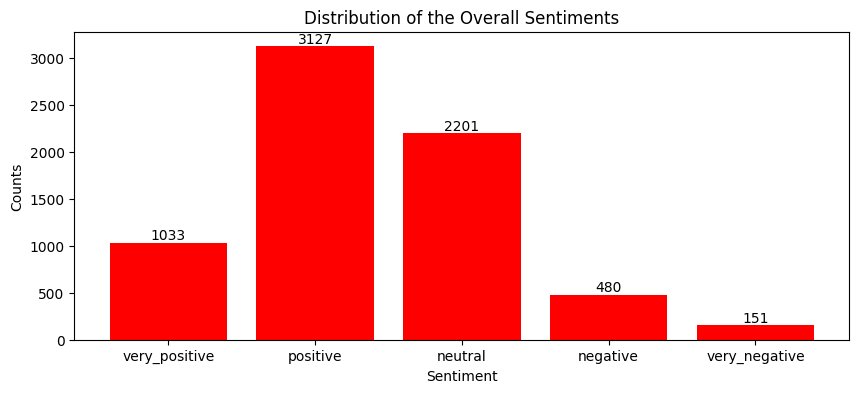

In [12]:
plt.figure(figsize = (10,4))

sentiment_counts = df['overall_sentiment'].value_counts()
bars = plt.bar(sentiment_counts.index, sentiment_counts.values, color='red')

plt.xlabel("Sentiment")
plt.ylabel("Counts")
plt.title("Distribution of the Overall Sentiments")


for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height, str(height), ha='center', va='bottom', fontsize=10)

plt.xticks(ticks=range(len(reverse_mapping.values())), labels=reverse_mapping.values())
plt.show()

#### Randomly resampling data - Upsampling

Majority class is of Positive and we will separate it out from the minority classes

In [13]:
mapping  # postive is encoded as 1

{'very_positive': 0,
 'positive': 1,
 'neutral': 2,
 'negative': 3,
 'very_negative': 4}

In [14]:
# Another way of getting the majority class is via maximum index
df['overall_sentiment'].value_counts().idxmax()

1

In [15]:
from sklearn.utils import resample

majority_class = df['overall_sentiment'].value_counts().idxmax()
majority_count = df['overall_sentiment'].value_counts().max()  # Gives number of record in majority class

# Separate majority class
df_majority = df[df["overall_sentiment"] == majority_class]

# Initialize list for resampled dataframe
resampled_frames = [df_majority]

# Resample each minority class to match majority class count
for cls in df['overall_sentiment'].unique():
    if cls == majority_class:
        continue
    df_minority = df[df["overall_sentiment"] == cls]
    df_minority_upsampled = resample(df_minority, replace=True, n_samples=majority_count, random_state=42)
    resampled_frames.append(df_minority_upsampled)

# Combining all resampled classes
df_upsample_with_resample = pd.concat(resampled_frames)
df_upsample_with_resample['overall_sentiment'].value_counts()


overall_sentiment
1    3127
0    3127
2    3127
3    3127
4    3127
Name: count, dtype: int64

In [16]:
df_upsample_with_resample.head(3)

,image_name,text_corrected,overall_sentiment
2,image_3.JPG,Sam Thorne @Strippin ( Follow Follow Saw every...,1
3,image_4.png,10 Year Challenge - Sweet Dee Edition,1
8,image_9.jpg,Fornite died in 10 months but Minecraft never ...,1


#### Randomly resampling data - Downsampling

In [17]:
from imblearn.under_sampling import RandomUnderSampler

X = df.drop('overall_sentiment', axis = 1)
y = df['overall_sentiment']

rus = RandomUnderSampler(random_state=42)
X_resampled, y_resampled = rus.fit_resample(X, y)

# Combine back into DataFrame
df_downsample_rus = pd.concat([X_resampled, y_resampled], axis=1)
df_downsample_rus.head()

,image_name,text_corrected,overall_sentiment
1874,image_1875.jpg,MAKES MLB DEBUT Citi t i MAI TIES CLIFF LEE IN...,0
3001,image_3002.png,I DON'T REMEMBER REPUBLICANS TALKING ABOUT UNI...,0
4298,image_4299.jpg,15 min in Midnight showing of X-Men: Days of F...,0
827,image_828.jpg,When you see another trailer loaded down with ...,0
3677,image_3678.jpg,YOU PUT YOUR WHAT IN HER WHAT? imgflip.com,0


In [18]:
df_downsample_rus['overall_sentiment'].value_counts()

overall_sentiment
0    151
1    151
2    151
3    151
4    151
Name: count, dtype: int64

We could have also used the resample module as we used for oversampling -

In [19]:
minority_class = df['overall_sentiment'].value_counts().idxmin()
minority_count = df['overall_sentiment'].value_counts().min()  # Gives number of record in minority class

df_minority = df[df["overall_sentiment"] == minority_class]
resampled_frames = [df_minority]

for cls in df['overall_sentiment'].unique():
    if cls == minority_class:
        continue
    df_majority = df[df["overall_sentiment"] == cls]
    df_majority_downsampled = resample(df_majority, replace=True, n_samples=minority_count, random_state=42)
    resampled_frames.append(df_majority_downsampled)


df_downsample_with_resample = pd.concat(resampled_frames)
df_downsample_with_resample['overall_sentiment'].value_counts()

overall_sentiment
4    151
0    151
1    151
2    151
3    151
Name: count, dtype: int64

## Working with upsampled dataset - Using Images as features for Classification

Images in the given directory called memes, which can be individually read using skimage.io.imread from the scikit-image module.

In [20]:
# Rearranging the index of the dataframe first

df_upsample_with_resample = df_upsample_with_resample.reset_index(drop=True)

In [21]:
df_upsample_with_resample.shape

(15635, 3)

Now, I was getting memory issues so I have to pick subsample from the dataset -

In [22]:
df_upsample_full_data = df_upsample_with_resample.copy() # Keeping a copy of the original

In [23]:
df_upsample_full_data['overall_sentiment'].value_counts()

overall_sentiment
1    3127
0    3127
2    3127
3    3127
4    3127
Name: count, dtype: int64

In [24]:
N = 600
sampled_dfs = []
used_images = set()

for label in df_upsample_full_data['overall_sentiment'].unique():
    subset = df_upsample_full_data[df_upsample_full_data['overall_sentiment'] == label]

    # Dropping global duplicates first
    unique_subset = subset[~subset['image_name'].isin(used_images)].drop_duplicates(subset='image_name')

    if len(unique_subset) >= N:
        sampled = unique_subset.sample(n=N, random_state=42)
    else:
        # Not enough unique images, allow sampling with replacement from full subset
        needed = N - len(unique_subset)
        remaining_samples = subset.sample(n=needed, replace=True, random_state=42)
        sampled = pd.concat([unique_subset, remaining_samples])

    used_images.update(sampled['image_name'].values)
    sampled_dfs.append(sampled)

df_upsample_with_resample = pd.concat(sampled_dfs).reset_index(drop=True)
df_upsample_with_resample['overall_sentiment'].value_counts()

overall_sentiment
1    600
0    600
2    600
3    600
4    600
Name: count, dtype: int64

In [25]:
df_upsample_with_resample[df_upsample_with_resample['image_name'].duplicated()]['overall_sentiment'].value_counts()

overall_sentiment
4    449
3    120
Name: count, dtype: int64

In [26]:
# Lets extract the images from the folder - this will be our features 
from skimage import io

images = []
for i in range(len(df_upsample_with_resample)):
    try:
        image_name_in_df = df_upsample_with_resample["image_name"][i]
        image=io.imread("images/" + image_name_in_df)
        images.append(image)
    except:
        print('Skipped for index ', i)
        print('File name is ', df_upsample_with_resample["image_name"][i])

Now if you try to read the above three images then it will throw `ValueError: all input arrays must have the same shape`. This happens when the image file is corrupted or has inconsistent channels. To handle this properly, we can force skimage to use Pillow via imageio or skip problematic images.

There will be an error of Truncated images for the image at index 2287.To handle this, explicitly configure it to load truncated images using Pillow via imageio.

In [ ]:
# Run the below code only when running the complete dataset or the specific indexes are included, else not needed
from PIL import ImageFile

# Allow loading of truncated image files
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [ ]:
from skimage.color import gray2rgb
import imageio.v2 as imageio

# 3815, 5317 these indexes have issues too which can be observed if you take full dataset
for i in [2287]:  # Indexes at which issues are observed
    image_path = "images/" + df_upsample_with_resample["image_name"][i]
    
    try:
        img = imageio.imread(image_path)
        print('Dimension of image : ', img.ndim)
        
        # Convert grayscale to RGB
        if img.ndim == 2:
            img = gray2rgb(img)
        
        # Convert RGBA to RGB
        if img.ndim == 3 and img.shape[-1] == 4:
            img = img[:, :, :3]

        images.append(img)
        
    except Exception as e:
        print(f"Skipped {image_path} due to error: {e}")

In [27]:
len(images)

3000

### Preprocessing the dataset

In [28]:
# Splitting the image data into training and testing sets
from sklearn.model_selection import train_test_split

train_images, test_images, train_labels, test_labels = train_test_split(images, 
                                                                        df_upsample_with_resample["overall_sentiment"], 
                                                                        test_size=0.1, 
                                                                        random_state=42)


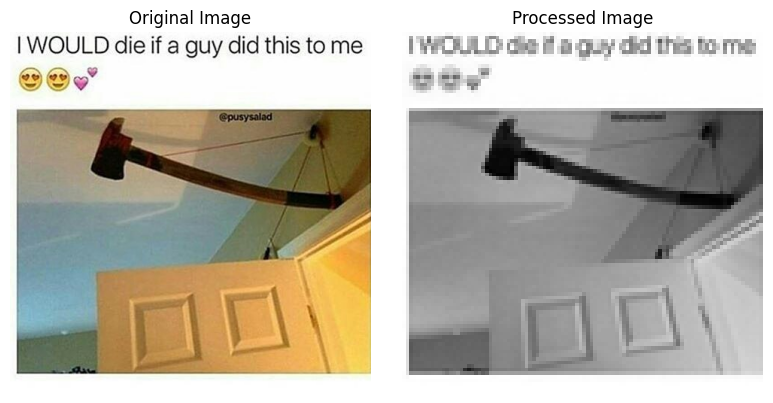

In [29]:
# Converting the images into greyscale to ensure uniformity and resizing the images for efficiency
# Let's see how it looks before converting all
from PIL import Image 
import matplotlib.pyplot as plt

# Original image
original = train_images[10]  # Image is in numpy array format
original = Image.fromarray(original)   # Converting the numpy array to PIL Image

# Processed PIL image which is converted to grayscale and resized
processed = original.convert("L").resize((100, 100))

# Plotting
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.imshow(original)
plt.title("Original Image")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(processed, cmap='gray')
plt.title("Processed Image")
plt.axis("off")

plt.tight_layout()
plt.show()

In [30]:
# Let's do the same for all records
# Now there are some images which has extra dimension that has to be handled
import numpy as np

x_train = []
for i in range(len(train_images)):
    img = train_images[i]
    if isinstance(img, np.ndarray):
        img = np.squeeze(img)  # Remove any singleton dimensions
        img = Image.fromarray(img.astype('uint8')).convert("L").resize((100, 100))
        x_train.append(np.array(img))

x_test = []
for i in range(len(test_images)):
    img = test_images[i]
    if isinstance(img, np.ndarray):
        img = np.squeeze(img)  # Remove any singleton dimensions
        img = Image.fromarray(img.astype('uint8')).convert("L").resize((100, 100))
        x_test.append(np.array(img))


In [31]:
# Normalising or Standardizing the training and testing image data
# Converting pixel values from [0, 255] to [0, 1] for model training

x_train = np.array(x_train)/255.0
x_test = np.array(x_test)/255.0

In [32]:
# Reshaping the training and testing image 
# Flattening each grayscale image (2D) into a 1D vector of size nx*ny
# For the final shape to be like - (samples, features) as suitable for traditional ML models

nsamples, nx, ny = x_train.shape
x_train = x_train.reshape((nsamples, nx*ny))

nsamples, nx, ny = x_test.shape
x_test = x_test.reshape((nsamples, nx*ny))

In [33]:
# Shape of the images became 1D

x_train[200].shape

(10000,)

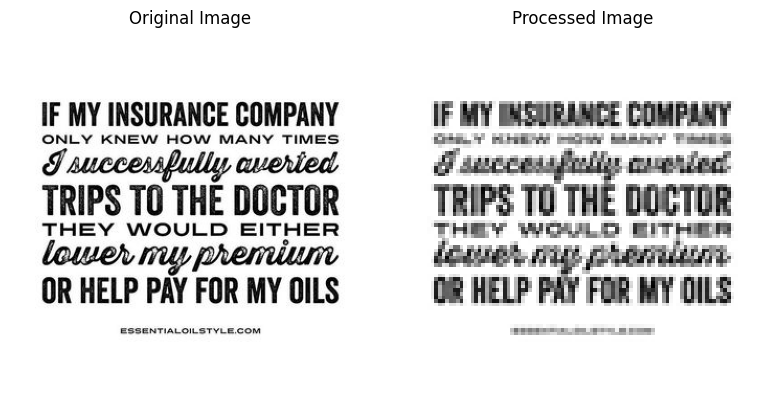

In [35]:
# Let's look at one preprocessed image beside original

plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.imshow(train_images[600])
plt.title("Original Image")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(np.reshape(x_train[600], (100, 100)), cmap='gray')  # As we flattened the x_train, we need to reshape it to view
plt.title("Processed Image")
plt.axis("off")

plt.tight_layout()
plt.show()

#### Using Logistic Regression

In [38]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

logreg_params = {
    'C': [0.1, 1.0, 10],
    'solver': ['liblinear', 'lbfgs'],
    'penalty': ['l2']
}

logreg = LogisticRegression(max_iter=1000, random_state=42)
logreg_grid = GridSearchCV(logreg, logreg_params, cv=3, scoring='accuracy', n_jobs=-1, verbose=1)
logreg_grid.fit(x_train, train_labels)
print("Best Logistic Regression:", logreg_grid.best_params_)

Fitting 3 folds for each of 6 candidates, totalling 18 fits
Best Logistic Regression: {'C': 1.0, 'penalty': 'l2', 'solver': 'lbfgs'}


In [39]:
logreg = LogisticRegression(**logreg_grid.best_params_, max_iter=1000, random_state=42)
logreg.fit(x_train, train_labels)

LogisticRegression(max_iter=1000, random_state=42)

In [40]:
logreg_prediction = logreg.predict(x_test) 

In [41]:
from sklearn.metrics import accuracy_score, f1_score, classification_report

logreg_score = accuracy_score(test_labels, logreg_prediction)    # Calculating the accuracy of the model
logreg_f1_score = f1_score(test_labels, logreg_prediction, average="macro")  # Calculating the average macro F1-score of the model
logreg_classification_report = classification_report(test_labels, logreg_prediction)   # Calculating classification report
print(logreg_classification_report)  
print("Accuracy: ", logreg_score*100, "%")
print("F1-Score (Macro): ", logreg_f1_score*100, "%")

              precision    recall  f1-score   support

           0       0.14      0.15      0.14        54
           1       0.31      0.22      0.26        73
           2       0.32      0.32      0.32        56
           3       0.44      0.47      0.45        60
           4       0.80      0.98      0.88        57

    accuracy                           0.42       300
   macro avg       0.40      0.43      0.41       300
weighted avg       0.40      0.42      0.41       300

Accuracy:  42.0 %
F1-Score (Macro):  41.044617638918766 %


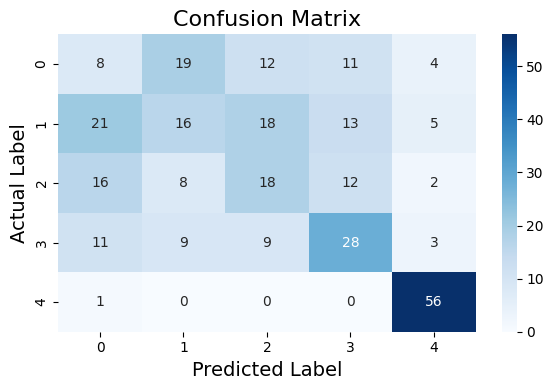

In [43]:
# Visualizing confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

logreg_cm = confusion_matrix(test_labels, logreg_prediction) 

# Plot heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(logreg_cm, annot=True, fmt='d', cmap='Blues', xticklabels=logreg.classes_, yticklabels=logreg.classes_)
plt.xlabel("Predicted Label", fontsize=14)
plt.ylabel("Actual Label", fontsize=14)
plt.title("Confusion Matrix", fontsize=16)
plt.tight_layout()
plt.show()

#### Using RandomForest Classifier

In [44]:
from sklearn.ensemble import RandomForestClassifier

# Define the model
rf = RandomForestClassifier(random_state=42, n_jobs=-1)

# Define hyperparameter grid
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'max_features': ['sqrt', 'log2']
    }

# Using GridSearchCV
grid_search = GridSearchCV(estimator = rf,
                           param_grid = param_grid,
                           cv = 3,             # For 3 fold cross validation
                           scoring = 'accuracy',
                           verbose = 2,
                           n_jobs = -1)        # To use all cores

In [45]:
# Fit the model
grid_search.fit(x_train, train_labels)

Fitting 3 folds for each of 48 candidates, totalling 144 fits


GridSearchCV(cv=3, estimator=RandomForestClassifier(n_jobs=-1, random_state=42),
             n_jobs=-1,
             param_grid={'max_depth': [None, 10, 20],
                         'max_features': ['sqrt', 'log2'],
                         'min_samples_leaf': [1, 2],
                         'min_samples_split': [2, 5],
                         'n_estimators': [100, 200]},
             scoring='accuracy', verbose=2)

In [46]:
print("Best Hyperparameters:", grid_search.best_params_)

Best Hyperparameters: {'max_depth': 20, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}


Picking the best parameters for the model

In [47]:
rf = RandomForestClassifier(**grid_search.best_params_, criterion="entropy", random_state=42)   
rf.fit(x_train, train_labels)

RandomForestClassifier(criterion='entropy', max_depth=20, max_features='log2',
                       min_samples_split=5, n_estimators=200, random_state=42)

In [48]:
rf_predictions = rf.predict(x_test) 

In [49]:
rf_score = accuracy_score(test_labels, rf_predictions)    # Calculating the accuracy of the model
rf_f1_score = f1_score(test_labels, rf_predictions, average="macro")  # Calculating the average macro F1-score of the model
rf_classification_report = classification_report(test_labels, rf_predictions)   # Calculating classification report
print(rf_classification_report)  
print("Accuracy: ", rf_score*100, "%")
print("F1-Score (Macro): ", rf_f1_score*100, "%")

              precision    recall  f1-score   support

           0       0.19      0.24      0.21        54
           1       0.31      0.22      0.26        73
           2       0.26      0.34      0.29        56
           3       0.41      0.35      0.38        60
           4       1.00      0.98      0.99        57

    accuracy                           0.42       300
   macro avg       0.43      0.43      0.43       300
weighted avg       0.43      0.42      0.42       300

Accuracy:  41.66666666666667 %
F1-Score (Macro):  42.660315667826794 %


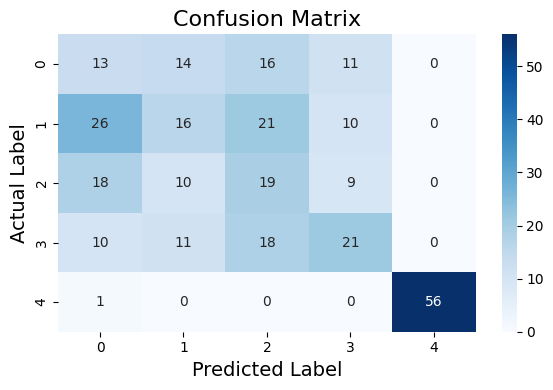

In [50]:
rf_cm = confusion_matrix(test_labels, rf_predictions) 

# Plot heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(rf_cm, annot=True, fmt='d', cmap='Blues', xticklabels=rf.classes_, yticklabels=rf.classes_)
plt.xlabel("Predicted Label", fontsize=14)
plt.ylabel("Actual Label", fontsize=14)
plt.title("Confusion Matrix", fontsize=16)
plt.tight_layout()
plt.show()

#### Using SVC Classification

In [51]:
from sklearn.svm import SVC

svc_params = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 'auto']
}

svc = SVC(random_state=42)
svc_grid = GridSearchCV(svc, svc_params, cv=3, scoring='accuracy', n_jobs=-1, verbose=1)
svc_grid.fit(x_train, train_labels)
print("Best SVC:", svc_grid.best_params_)

Fitting 3 folds for each of 12 candidates, totalling 36 fits
Best SVC: {'C': 0.1, 'gamma': 'scale', 'kernel': 'linear'}


In [52]:
svc = SVC(**svc_grid.best_params_, random_state=42)
svc.fit(x_train, train_labels)

SVC(C=0.1, kernel='linear', random_state=42)

In [53]:
svc_predictions = svc.predict(x_test) 

In [54]:
svc_score = accuracy_score(test_labels, svc_predictions)    # Calculating the accuracy of the model
svc_f1_score = f1_score(test_labels, svc_predictions, average="macro")  # Calculating the average macro F1-score of the model
svc_classification_report = classification_report(test_labels, svc_predictions)   # Calculating classification report
print(svc_classification_report)  
print("Accuracy: ", svc_score*100, "%")
print("F1-Score (Macro): ", svc_f1_score*100, "%")

              precision    recall  f1-score   support

           0       0.19      0.26      0.22        54
           1       0.34      0.22      0.27        73
           2       0.36      0.36      0.36        56
           3       0.48      0.42      0.45        60
           4       0.79      1.00      0.88        57

    accuracy                           0.44       300
   macro avg       0.43      0.45      0.43       300
weighted avg       0.43      0.44      0.43       300

Accuracy:  44.0 %
F1-Score (Macro):  43.48862932831071 %


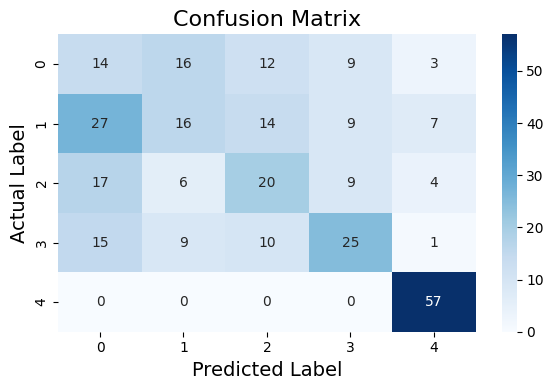

In [55]:
svc_cm = confusion_matrix(test_labels, svc_predictions) 

# Plot heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(svc_cm, annot=True, fmt='d', cmap='Blues', xticklabels=svc.classes_, yticklabels=svc.classes_)
plt.xlabel("Predicted Label", fontsize=14)
plt.ylabel("Actual Label", fontsize=14)
plt.title("Confusion Matrix", fontsize=16)
plt.tight_layout()
plt.show()

#### Using KNN Classification

In [56]:
from sklearn.neighbors import KNeighborsClassifier

knn_params = {
    'n_neighbors': [3, 5, 7],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

knn = KNeighborsClassifier()
knn_grid = GridSearchCV(knn, knn_params, cv=3, scoring='accuracy', n_jobs=-1, verbose=1)
knn_grid.fit(x_train, train_labels)
print("Best KNN:", knn_grid.best_params_)

Fitting 3 folds for each of 12 candidates, totalling 36 fits
Best KNN: {'metric': 'euclidean', 'n_neighbors': 3, 'weights': 'distance'}


In [57]:
knn = KNeighborsClassifier(**knn_grid.best_params_)   
knn.fit(x_train, train_labels)

KNeighborsClassifier(metric='euclidean', n_neighbors=3, weights='distance')

In [58]:
knn_prediction = knn.predict(x_test)

In [59]:
knn_score = accuracy_score(test_labels, knn_prediction)    # Calculating the accuracy of the model
knn_f1_score = f1_score(test_labels, knn_prediction, average="macro")  # Calculating the average macro F1-score of the model
knn_classification_report = classification_report(test_labels, knn_prediction)   # Calculating classification report
print(knn_classification_report)  
print("Accuracy: ", knn_score*100, "%")
print("F1-Score (Macro): ", knn_f1_score*100, "%")

              precision    recall  f1-score   support

           0       0.16      0.13      0.14        54
           1       0.22      0.11      0.15        73
           2       0.29      0.36      0.32        56
           3       0.40      0.43      0.42        60
           4       0.67      0.98      0.79        57

    accuracy                           0.39       300
   macro avg       0.35      0.40      0.36       300
weighted avg       0.34      0.39      0.35       300

Accuracy:  39.0 %
F1-Score (Macro):  36.34389856006877 %


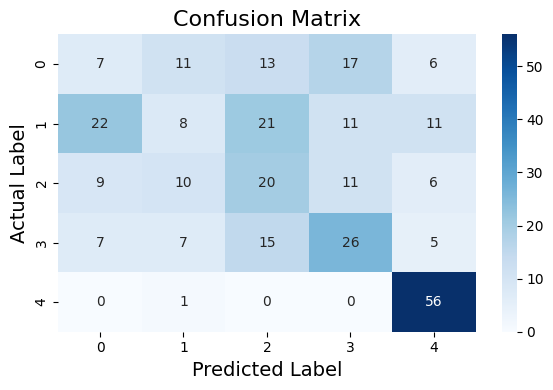

In [60]:
knn_cm = confusion_matrix(test_labels, knn_prediction) 

# Plot heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(knn_cm, annot=True, fmt='d', cmap='Blues', xticklabels=knn.classes_, yticklabels=knn.classes_)
plt.xlabel("Predicted Label", fontsize=14)
plt.ylabel("Actual Label", fontsize=14)
plt.title("Confusion Matrix", fontsize=16)
plt.tight_layout()
plt.show()

#### Extra Tree Classifier

In [61]:
from sklearn.ensemble import ExtraTreesClassifier

et_params = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5]
}

et = ExtraTreesClassifier(random_state=42)
et_grid = GridSearchCV(et, et_params, cv=3, scoring='accuracy', n_jobs=-1, verbose=1)
et_grid.fit(x_train, train_labels)
print("Best ExtraTrees:", et_grid.best_params_)

Fitting 3 folds for each of 12 candidates, totalling 36 fits
Best ExtraTrees: {'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 100}


In [62]:
et = ExtraTreesClassifier(**et_grid.best_params_, random_state=42)
et.fit(x_train, train_labels)

ExtraTreesClassifier(max_depth=10, random_state=42)

In [63]:
et_prediction = et.predict(x_test)

In [64]:
et_score = accuracy_score(test_labels, et_prediction)    # Calculating the accuracy of the model
et_f1_score = f1_score(test_labels, et_prediction, average="macro")  # Calculating the average macro F1-score of the model
et_classification_report = classification_report(test_labels, et_prediction)   # Calculating classification report
print(et_classification_report)  
print("Accuracy: ", et_score*100, "%")
print("F1-Score (Macro): ", et_f1_score*100, "%")

              precision    recall  f1-score   support

           0       0.22      0.31      0.26        54
           1       0.31      0.22      0.26        73
           2       0.27      0.34      0.30        56
           3       0.49      0.35      0.41        60
           4       1.00      0.98      0.99        57

    accuracy                           0.43       300
   macro avg       0.46      0.44      0.44       300
weighted avg       0.45      0.43      0.43       300

Accuracy:  43.0 %
F1-Score (Macro):  44.242876642016014 %


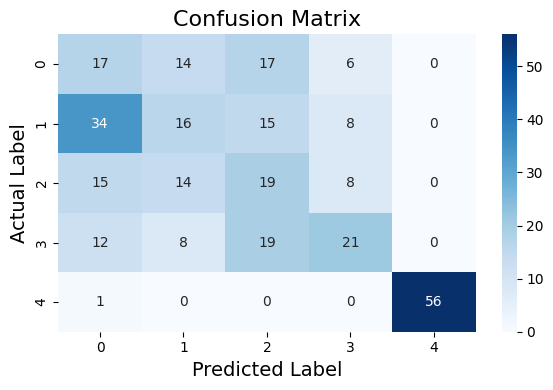

In [65]:
et_cm = confusion_matrix(test_labels, et_prediction) 

# Plot heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(et_cm, annot=True, fmt='d', cmap='Blues', xticklabels=et.classes_, yticklabels=et.classes_)
plt.xlabel("Predicted Label", fontsize=14)
plt.ylabel("Actual Label", fontsize=14)
plt.title("Confusion Matrix", fontsize=16)
plt.tight_layout()
plt.show()

#### Interpretation of models

In [68]:
accuracy_frame = pd.DataFrame()

models = ['Logistic Regression', 'Random Forest Classifier', 'SVC Classifier', 'KNN Classifier', 'Extra Tree Classifier']
f1_scores = [logreg_f1_score, rf_f1_score, svc_f1_score, knn_f1_score, et_f1_score]

accuracy_frame['Models'] = models
accuracy_frame['F1_Scores'] = f1_scores

accuracy_frame

,Models,F1_Scores
0,Logistic Regression,0.410446
1,Random Forest Classifier,0.426603
2,SVC Classifier,0.434886
3,KNN Classifier,0.363439
4,Extra Tree Classifier,0.442429


Extra Trees Classifier performed best here. It can handle noise and high dimensionality well. Tree ensembles work well on small, noisy datasets, especially with high-dimensional features like raw pixel values. Extra Trees does more random splitting leading to better generalization in small samples.

SVC Classifier showed second best performance due to margin maximization. It performs well on small datasets but struggle with noisy or high dimensional inputs (as in our case). 

Random Forest performed slightly worse than Extra Trees likely due to lower variance and splitting strategy.

Logistic Regression cannot capture complex pixel patterns well.                                     

KNN Classifier are very sensitive to high-dimensionality, sparse data, and imbalanced classes. Suffers with reduced data and noisy pixels. Pixel data has too much noise for distance-based methods to work well.    


**In order to Improve Accuracy and F1 Score**
* We can use more data. Here we are using about 16% of total data. Increasing the number would require higher computation.
* Current pixels are 100×100 grayscale giving 10,000 features. Using more features and then eeducing dimension can work well.
* Images could be resized for limited computation.
* LightGBM or XGBoost with deeper tuning could be used, but these models needs higher computation.


### Training the models in an optimized way

Let's try to optimize the data more and see the difference.

In [110]:
# Using more data -> 600 to 1000 now

N = 1000
sampled_dfs = []
used_images = set()

for label in df_upsample_full_data['overall_sentiment'].unique():
    subset = df_upsample_full_data[df_upsample_full_data['overall_sentiment'] == label]

    # Dropping global duplicates first
    unique_subset = subset[~subset['image_name'].isin(used_images)].drop_duplicates(subset='image_name')

    if len(unique_subset) >= N:
        sampled = unique_subset.sample(n=N, random_state=42)
    else:
        # Not enough unique images, allow sampling with replacement from full subset
        needed = N - len(unique_subset)
        remaining_samples = subset.sample(n=needed, replace=True, random_state=42)
        sampled = pd.concat([unique_subset, remaining_samples])

    used_images.update(sampled['image_name'].values)
    sampled_dfs.append(sampled)

df_upsample_with_resample = pd.concat(sampled_dfs).reset_index(drop=True)
df_upsample_with_resample['overall_sentiment'].value_counts()

overall_sentiment
1    1000
0    1000
2    1000
3    1000
4    1000
Name: count, dtype: int64

In [111]:
# Run the below code only when running the complete dataset or the specific indexes are included, else not needed
from PIL import ImageFile

# Allow loading of truncated image files
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [118]:
images = []
for i in range(len(df_upsample_with_resample)):
    try:
        image_name_in_df = df_upsample_with_resample["image_name"][i]
        image=io.imread("images/" + image_name_in_df)
        images.append(image)
    except:
        print('Skipped for index ', i)
        print('File name is ', df_upsample_with_resample["image_name"][i])

E:\7. Deep Learning\venv\lib\site-packages\PIL\Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Skipped for index  1509
File name is  image_4924.jpg


In [120]:
from skimage.color import gray2rgb
import imageio.v2 as imageio


for i in [1509]:  
    image_path = "images/" + df_upsample_with_resample["image_name"][i]
    
    try:
        img = imageio.imread(image_path)
        print('Dimension of image : ', img.ndim)
        
        # Convert grayscale to RGB
        if img.ndim == 2:
            img = gray2rgb(img)
        
        # Convert RGBA to RGB
        if img.ndim == 3 and img.shape[-1] == 4:
            img = img[:, :, :3]

        images.append(img)
        
    except Exception as e:
        print(f"Skipped {image_path} due to error: {e}")

Dimension of image :  3


In [121]:
len(images)

5000

In [122]:
train_images, test_images, train_labels, test_labels = train_test_split(images, 
                                                                        df_upsample_with_resample["overall_sentiment"], 
                                                                        stratify = df_upsample_with_resample["overall_sentiment"],
                                                                        test_size=0.1, 
                                                                        random_state=42)

In [123]:
len(train_images), len(test_images)

(4500, 500)

In [124]:
x_train = []
for i in range(len(train_images)):
    img = train_images[i]
    if isinstance(img, np.ndarray):
        img = np.squeeze(img)  # Remove any singleton dimensions
        img = Image.fromarray(img.astype('uint8')).convert("L").resize((100, 100))  
        x_train.append(np.array(img))

x_test = []
for i in range(len(test_images)):
    img = test_images[i]
    if isinstance(img, np.ndarray):
        img = np.squeeze(img)  # Remove any singleton dimensions
        img = Image.fromarray(img.astype('uint8')).convert("L").resize((100, 100))
        x_test.append(np.array(img))

In [125]:
x_train = np.array(x_train)/255.0
x_test = np.array(x_test)/255.0

nsamples, nx, ny = x_train.shape
x_train = x_train.reshape((nsamples, nx*ny))

nsamples, nx, ny = x_test.shape
x_test = x_test.reshape((nsamples, nx*ny))

In [126]:
x_train.shape, train_labels.shape

((4500, 10000), (4500,))

In [127]:
# let's use PCA to reduce the dimension
from sklearn.decomposition import PCA

pca = PCA()
pca.fit_transform(x_train)

array([[-1.15552403e+01,  1.45753353e+01,  1.12825137e+01, ...,
         3.67463499e-20,  8.51493934e-21,  5.42509792e-21],
       [-3.78917970e-01,  7.30080989e+00,  7.99002762e+00, ...,
         3.67463499e-20,  8.51493934e-21,  5.42509792e-21],
       [ 8.60438457e+00,  1.50646065e+01,  5.08614359e+00, ...,
        -8.08845201e-17, -9.42709604e-19, -5.95602762e-17],
       ...,
       [ 4.18583139e+01,  4.56920491e+00, -7.83216373e+00, ...,
         3.67463499e-20,  8.51493934e-21,  5.42509792e-21],
       [-5.41805202e+00,  1.93830555e+01,  9.09970496e+00, ...,
         3.67463499e-20,  8.51493934e-21,  5.42509792e-21],
       [ 3.00625168e-01, -8.10242040e+00,  3.42671160e+00, ...,
         6.58445860e-16, -2.46092415e-16,  9.68961062e-17]])

In [128]:
len(pca.explained_variance_ratio_)

4500

In [129]:
explained_ratio = pd.DataFrame(pca.explained_variance_ratio_.cumsum())
features_to_take = explained_ratio[explained_ratio[0] > 0.80].head(1).index  # Picking number of features just above 80%

In [130]:
pca = PCA(n_components=features_to_take[0])
pca.fit(x_train)

PCA(n_components=105)

In [131]:
x_train_pca = pca.transform(x_train)
x_test_pca = pca.transform(x_test)

In [132]:
et = ExtraTreesClassifier(**et_grid.best_params_, random_state=42)
et.fit(x_train_pca, train_labels)
et_prediction = et.predict(x_test_pca)

In [133]:
et_score = accuracy_score(test_labels, et_prediction)    # Calculating the accuracy of the model
et_f1_score = f1_score(test_labels, et_prediction, average="macro")  # Calculating the average macro F1-score of the model
et_classification_report = classification_report(test_labels, et_prediction)   # Calculating classification report
print(et_classification_report)  
print("Accuracy: ", et_score*100, "%")
print("F1-Score (Macro): ", et_f1_score*100, "%")

              precision    recall  f1-score   support

           0       0.27      0.36      0.31       100
           1       0.32      0.37      0.34       100
           2       0.30      0.26      0.28       100
           3       0.79      0.64      0.71       100
           4       0.98      0.79      0.87       100

    accuracy                           0.48       500
   macro avg       0.53      0.48      0.50       500
weighted avg       0.53      0.48      0.50       500

Accuracy:  48.4 %
F1-Score (Macro):  50.134658846793876 %


F1-Score is now increased from 44 to 50%. Using more examples can increase the accuracy more.

Let's try using LightGBM with PCA -

In [139]:
from lightgbm import LGBMClassifier

lgbm = LGBMClassifier(n_estimators=100, learning_rate = 0.05, force_col_wise=True, random_state=42)
lgbm.fit(x_train_pca, train_labels)
lgbm_prediction = lgbm.predict(x_test_pca)


[LightGBM] [Info] Total Bins 26774
[LightGBM] [Info] Number of data points in the train set: 4500, number of used features: 105
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438


In [140]:
lgbm_score = accuracy_score(test_labels, lgbm_prediction)    # Calculating the accuracy of the model
lgbm_f1_score = f1_score(test_labels, lgbm_prediction, average="macro")  # Calculating the average macro F1-score of the model
lgbm_classification_report = classification_report(test_labels, lgbm_prediction)   # Calculating classification report
print(lgbm_classification_report)  
print("Accuracy: ", lgbm_score*100, "%")
print("F1-Score (Macro): ", lgbm_f1_score*100, "%")

              precision    recall  f1-score   support

           0       0.30      0.32      0.31       100
           1       0.33      0.32      0.33       100
           2       0.28      0.28      0.28       100
           3       0.79      0.80      0.80       100
           4       1.00      0.97      0.98       100

    accuracy                           0.54       500
   macro avg       0.54      0.54      0.54       500
weighted avg       0.54      0.54      0.54       500

Accuracy:  53.800000000000004 %
F1-Score (Macro):  53.96003395993914 %


Let's check ROC_AUC Curve and if there is any overfitting

In [134]:
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score
from sklearn.preprocessing import label_binarize


def evaluate_model_performance(model, X_train, y_train, X_test, y_test, class_labels=None, model_name="Model"):
    # Predict
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    # Accuracy
    train_acc = accuracy_score(y_train, y_train_pred)
    test_acc = accuracy_score(y_test, y_test_pred)

    # Print overfitting/underfitting diagnosis
    print(f"{model_name} Accuracy")
    print(f"Train Accuracy: {train_acc:.4f}")
    print(f"Test Accuracy : {test_acc:.4f}")
    if abs(train_acc - test_acc) > 0.1:
        print("Likely Overfitting (large gap between train and test)")
    elif train_acc < 0.7 and test_acc < 0.7:
        print("Likely Underfitting (both scores are low)")
    else:
        print("No major signs of overfitting or underfitting.")

    # ROC-AUC (One-vs-Rest for multi-class)
    y_test_bin = label_binarize(y_test, classes=np.unique(y_test))
    if hasattr(model, "predict_proba"):
        y_score = model.predict_proba(X_test)
    elif hasattr(model, "decision_function"):
        y_score = model.decision_function(X_test)
    else:
        print("Model does not support probability or decision scores for ROC.")
        return

    # ROC AUC Score (macro-average)
    roc_auc = roc_auc_score(y_test_bin, y_score, average="macro", multi_class="ovr")
    print(f"\nROC AUC Score (Macro Avg): {roc_auc:.4f}")

    # Plot ROC Curve (macro-average)
    plt.figure(figsize=(6, 5))
    for i in range(y_test_bin.shape[1]):
        fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_score[:, i])
        plt.plot(fpr, tpr, label=f"Class {i}")

    plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC Curve: {model_name}\nMacro ROC AUC = {roc_auc:.4f}")
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


ExtraTree Classifier Accuracy
Train Accuracy: 0.8764
Test Accuracy : 0.4840
Likely Overfitting (large gap between train and test)

ROC AUC Score (Macro Avg): 0.7761


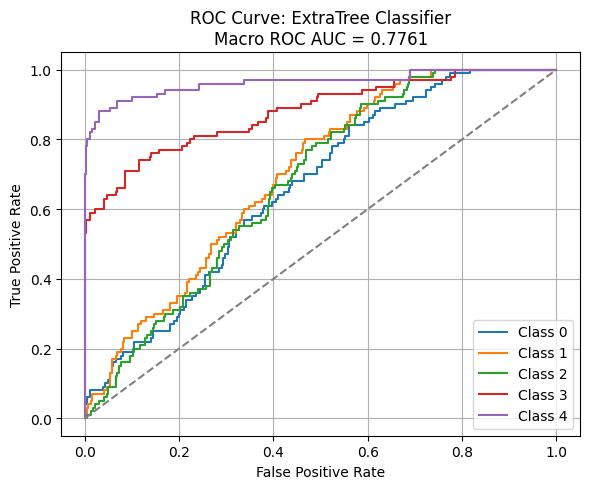

In [135]:
evaluate_model_performance(et, x_train_pca, train_labels, x_test_pca, test_labels, class_labels=None, model_name="ExtraTree Classifier")

LightGBM Classifier Accuracy
Train Accuracy: 0.9980
Test Accuracy : 0.5380
Likely Overfitting (large gap between train and test)

ROC AUC Score (Macro Avg): 0.8174


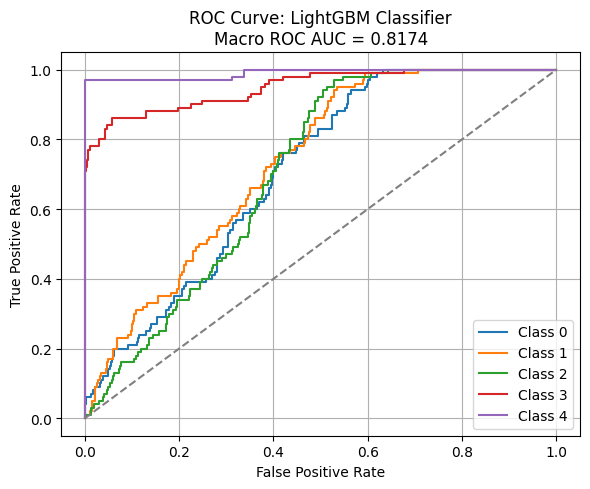

In [141]:
evaluate_model_performance(lgbm, x_train_pca, train_labels, x_test_pca, test_labels, class_labels=None, model_name="LightGBM Classifier")

#### Let's try using XGBoost Classifier with more hyperparameter tuning

In [175]:
pca = PCA(n_components=60)
pca.fit(x_train)

x_train_pca = pca.transform(x_train)
x_test_pca = pca.transform(x_test)

In [176]:
from xgboost import XGBClassifier


xgb = XGBClassifier(
    n_estimators=300,
    learning_rate=0.02,         
    max_depth=4,                
    subsample=0.7,
    colsample_bytree=0.7,
    reg_alpha=6.0,             
    reg_lambda=3.0,             
    min_child_weight=10,       
    eval_metric='mlogloss',
    random_state=42
)


xgb.fit(
    x_train_pca, train_labels
)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.7, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.02, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=10, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=300, n_jobs=None,
              num_parallel_tree=None, ...)

Extra Tree Classifier Accuracy
Train Accuracy: 0.8067
Test Accuracy : 0.4760
Likely Overfitting (large gap between train and test)

ROC AUC Score (Macro Avg): 0.7560


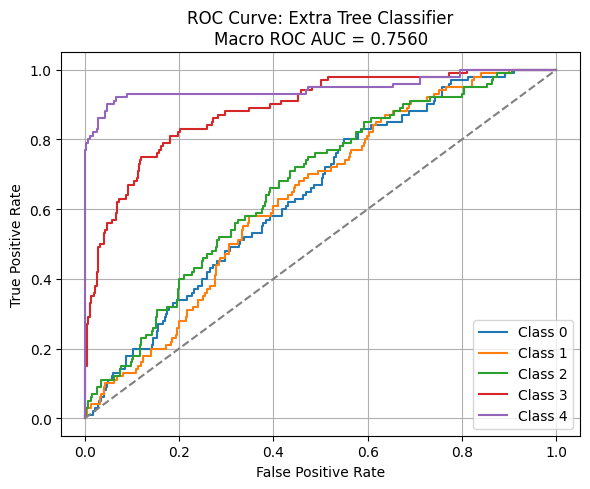

In [177]:
evaluate_model_performance(xgb, x_train_pca, train_labels, x_test_pca, test_labels, class_labels=None, model_name="Extra Tree Classifier")

Increasing training data can avoid the overfitting.

## Working with upsampled dataset - Using text as features for Classification

In [178]:
df_upsample_full_data.head()

,image_name,text_corrected,overall_sentiment
0,image_3.JPG,Sam Thorne @Strippin ( Follow Follow Saw every...,1
1,image_4.png,10 Year Challenge - Sweet Dee Edition,1
2,image_9.jpg,Fornite died in 10 months but Minecraft never ...,1
3,image_10.png,FACEBOOK '10 YEAR CHALLENGE': A PLOY OR A SIMP...,1
4,image_13.png,I did the Facebook 10 year challenge and it wa...,1


In [179]:
df_upsample_full_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15635 entries, 0 to 15634
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   image_name         15635 non-null  object
 1   text_corrected     15630 non-null  object
 2   overall_sentiment  15635 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 366.6+ KB


In [180]:
# There are some null data in text_corrected. Let's drop that

df_upsample_full_data = df_upsample_full_data.dropna(subset = ['text_corrected'])
df_upsample_full_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 15630 entries, 0 to 15634
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   image_name         15630 non-null  object
 1   text_corrected     15630 non-null  object
 2   overall_sentiment  15630 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 488.4+ KB


In [197]:
import re

def clean_text(text):
    text=text.lower() 
    text=re.sub(r"[^a-z0-9]", " ", text)  
    text=re.sub(r"\s+", " ", text) 
    return text

In [198]:
df_upsample_full_data['text_corrected'] = df_upsample_full_data['text_corrected'].apply(clean_text)

In [223]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import OneHotEncoder
from nltk.corpus import stopwords

# Creating an instance of the TfidfVectorizer class
vectorizer=TfidfVectorizer(max_features=1000, stop_words=stopwords.words("english"), ngram_range=(1, 2))    

x = vectorizer.fit_transform(df_upsample_full_data["text_corrected"].values.astype("U"))

# Original labels
y_raw = df_upsample_full_data['overall_sentiment'].values.reshape(-1, 1)

# One-hot encode labels
encoder = OneHotEncoder()
y = encoder.fit_transform(y_raw).toarray()  

# Stratified split using original labels to maintain class balance
x_train, x_test, y_train, y_test = train_test_split(
    x, y,
    test_size=0.2,
    stratify=y_raw,
    random_state=42
)

In [224]:
# Converting the sparse matrices into dense matrices.
x_train = x_train.toarray()
x_test = x_test.toarray()

# Converting One-Hot encoded to 1D array
y_train = np.argmax(y_train, axis=1)
y_test = np.argmax(y_test, axis=1)

#### Using SGD Classifier

In [225]:
# Performing Stochastic Gradient Descent for optimization
from sklearn.linear_model import SGDClassifier

sgd=SGDClassifier(loss="perceptron", penalty="l2", max_iter=100000, random_state=42, n_jobs=-1)   
sgd.fit(x_train, y_train)

SGDClassifier(loss='perceptron', max_iter=100000, n_jobs=-1, random_state=42)

In [226]:
sgd_predictions=sgd.predict(x_test)   
sgd_predictions

array([1, 4, 1, ..., 0, 2, 4], dtype=int64)

In [227]:
sgd_score=accuracy_score(y_test, sgd_predictions) 
sgd_f1_score=f1_score(y_test, sgd_predictions, average="weighted")   
print(classification_report(y_test, sgd_predictions))  
print("Accuracy: ", sgd_score*100, "%")
print("F1-Score (Weighted): ", sgd_f1_score*100, "%")

              precision    recall  f1-score   support

           0       0.48      0.22      0.30       625
           1       0.32      0.21      0.26       625
           2       0.33      0.69      0.44       625
           3       0.65      0.46      0.54       625
           4       0.94      0.99      0.96       626

    accuracy                           0.51      3126
   macro avg       0.54      0.51      0.50      3126
weighted avg       0.54      0.51      0.50      3126

Accuracy:  51.34357005758158 %
F1-Score (Weighted):  49.9954990081526 %


#### Using MultinomialNB

In [234]:
from sklearn.naive_bayes import MultinomialNB

mnb = MultinomialNB(alpha=0.3) 
mnb.fit(x_train, y_train)  

MultinomialNB(alpha=0.3)

In [235]:
mnb_predictions=mnb.predict(x_test)   
mnb_predictions

array([3, 4, 0, ..., 3, 0, 4], dtype=int64)

In [236]:
mnb_score=accuracy_score(y_test, mnb_predictions)  
mnb_f1_score=f1_score(y_test, mnb_predictions, average="weighted")   
print(classification_report(y_test, mnb_predictions, zero_division=1))
print("Accuracy: ", mnb_score*100, "%")
print("F1-Score (Weighted): ", mnb_f1_score*100, "%")

              precision    recall  f1-score   support

           0       0.40      0.45      0.42       625
           1       0.33      0.28      0.30       625
           2       0.41      0.37      0.39       625
           3       0.53      0.55      0.54       625
           4       0.78      0.84      0.81       626

    accuracy                           0.50      3126
   macro avg       0.49      0.50      0.49      3126
weighted avg       0.49      0.50      0.49      3126

Accuracy:  49.80806142034549 %
F1-Score (Weighted):  49.213867078863736 %


MultinomialNB Classifier Accuracy
Train Accuracy: 0.5707
Test Accuracy : 0.4981
Likely Underfitting (both scores are low)

ROC AUC Score (Macro Avg): 0.7946


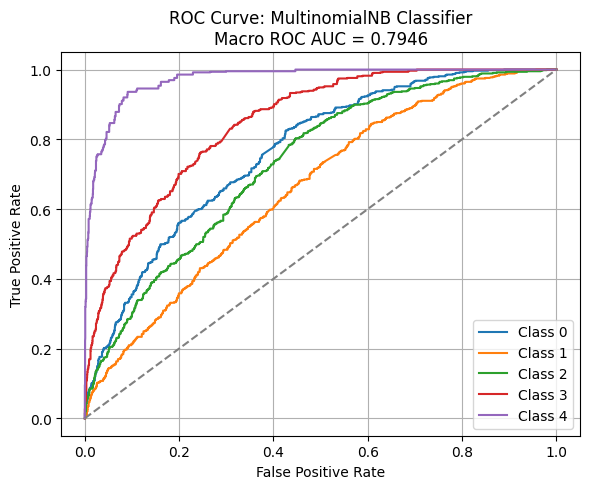

In [237]:
evaluate_model_performance(mnb, x_train, y_train, x_test, y_test, class_labels=None, model_name="MultinomialNB Classifier")